## pythonでjpegファイルのバイナリデータから画素値情報を取り出すトライアル。

pythonのコーディングを学ぶ課題としてjpegフォーマットをバイナリデータから画素値に変換するトライアルをしてみる。
すこし符合理論や信号処理の復習も兼ねる

参考にしたサイト
* [https://www.setsuki.com/hsp/ext/jpg.htm](https://www.setsuki.com/hsp/ext/jpg.htm)
* [https://hp.vector.co.jp/authors/VA032610/JPEGFormat/StructureOfJPEG.htm](https://hp.vector.co.jp/authors/VA032610/JPEGFormat/StructureOfJPEG.htm)
* [http://www.siisise.net/jpeg.html](http://www.siisise.net/jpeg.html)
* [https://www.w3.org/Graphics/JPEG/jfif3.pdf](https://www.w3.org/Graphics/JPEG/jfif3.pdf)

とりあえずターゲットのjpegファイルを表示しておく(matplotlib使えば簡単に変換・描画できる)

[]

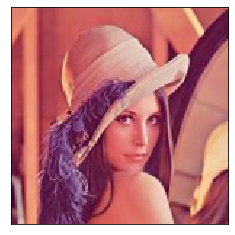

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


f_name="target_data\Lenna.jpg"

img = mpimg.imread(f_name) #jpegファイルの読み込み

imgplot = plt.imshow(img)  #jpegファイルの描画
imgplot.axes.set_xticks([]) #x軸の目盛を削除
imgplot.axes.set_yticks([]) #y軸の目盛を削除

### 1.jpegファイルのHEXダンプ

"rb"モードでファイルをオープンし、バイナリデータとしてjpgファイルをbytes型の配列sとして読み込み、16データ1行単位でhexダンプ出力  
データ量の都合途中まで(16\*32\*3= 1536bytes)の出力とする。


In [2]:
f=open(f_name,"rb")
s=f.read()
f.close


cnt=0
rows=0

for byte in s:  
    if( rows == 32 * 3 and cnt%16==0 ): break
    if (cnt%16==0):
        if(rows %32 ==0 ):       
            print("")
            print("       ",end="")
            for i in range(16):
                print(" {:1x} ".format(i),end="")
            print("")
        print("{:03x}# : ".format(rows),end="")
        
    print("{:02x} ".format(byte),end="")
 
    cnt+=1
    if (cnt%16==0):
        print("")
        rows+=1
        
print("")    
print ("......(omittion)")



        0  1  2  3  4  5  6  7  8  9  a  b  c  d  e  f 
000# : ff d8 ff e0 00 10 4a 46 49 46 00 01 01 01 00 48 
001# : 00 48 00 00 ff db 00 43 00 05 03 04 04 04 03 05 
002# : 04 04 04 05 05 05 06 07 0c 08 07 07 07 07 0f 0b 
003# : 0b 09 0c 11 0f 12 12 11 0f 11 11 13 16 1c 17 13 
004# : 14 1a 15 11 11 18 21 18 1a 1d 1d 1f 1f 1f 13 17 
005# : 22 24 22 1e 24 1c 1e 1f 1e ff db 00 43 01 05 05 
006# : 05 07 06 07 0e 08 08 0e 1e 14 11 14 1e 1e 1e 1e 
007# : 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 
008# : 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 
009# : 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e 1e ff c0 
00a# : 00 11 08 00 96 00 96 03 01 22 00 02 11 01 03 11 
00b# : 01 ff c4 00 1f 00 00 01 05 01 01 01 01 01 01 00 
00c# : 00 00 00 00 00 00 00 01 02 03 04 05 06 07 08 09 
00d# : 0a 0b ff c4 00 b5 10 00 02 01 03 03 02 04 03 05 
00e# : 05 04 04 00 00 01 7d 01 02 03 00 04 11 05 12 21 
00f# : 31 41 06 13 51 61 07 22 71 14 32 81 91 a1 08 23 
010# : 42 b1 c1 15 52 d1 f0 24 33 62 72 82 09 0

### 2.pegファイルのマーカー/セグメント/イメージデータ構造の抽出

バイナリデータをバイト単位でチェックし0xFFXX のパターン(マーカー)を検出した場合セグメントとして処理し
セグメント名(辞書定義されていればその文字列、それ以外ならHEX文字列)、セグメント長、セグメントデータ(bytes型)を取り出し、リストjpeg_structに追加。

"SOI","EOI"に関してはマーカーのみなので、セグメント長、セグメントデータなしとしてがjpeg_structリスト上はセグメントと同列に扱う

"SOS"セグメント以降はイメージデータとして"EOI"を検知するまでのデータをイメージデータとして文字列"IMG"及びそのサイズ、データ(bytes型)をリストjpeg_structリストに追加(イメージデータはセグメントではないがjpeg_structリスト上は名称"IMG"をつけてセグメントと同列に扱うことにする)

マーカー0xFF00に関しては0x00のバイナリデータとして変換する。

In [3]:
marker_def={0xd8:"SOI",0xd9:"EOI",0xda:"SOS",0xe0:"APP0",0xdb:"DQT",0xc0:"SOF0",0xc2:"SOF2",0xc4:"DHT"}

flag_marker= False
flag_seg=False
flag_seg_cnt=False
flag_seg_data=False
flag_SOI= False
flag_EOI= False
flag_SOS= False
flag_err=False
jpeg_struct=[]
seg_buf=[]
byte_bufs=b''
seg_count=0

f=open(f_name,"rb")
s=f.read()
f.close


for byte in s:
    if flag_marker==False and byte==0xFF :  #マーカーの判定
        flag_marker=True
        
    else:
        
        #######    マーカー処理  #########
        if flag_marker==True :  
            #FF00マーカ処理
            if byte==0x00 :
                byte_bufs=byte_bufs+bytes.fromhex("{:02X}".format(0))              
            #辞書定義済みマーカ
            elif byte in marker_def: 
                #SOI判定       
                if flag_SOI==False :
                    if marker_def[byte]=="SOI" :           
                        flag_SOI=True
                        jpeg_struct=jpeg_struct+[["SOI"]]
                    else:
                        flag_err=True;
                        
                #EOI判定    
                elif marker_def[byte]=="EOI":               
                    #IMAGE DATA格納
                    #jpeg_struct=jpeg_struct+[["IMG","{:d}".format(len(byte_bufs)),byte_bufs.hex()]] 
                    jpeg_struct=jpeg_struct+[["IMG","{:d}".format(len(byte_bufs)),byte_bufs]]
                    jpeg_struct=jpeg_struct+[["EOI"]] 
                    flag_EOI=True    
                    
                #その他定義済マーカ（セグメント処理）
                elif byte in marker_def:               
                    seg_buf=[""+marker_def[byte]]
                    flag_seg=True
                    #SOS判定
                    if marker_def[byte]=="SOS":
                        flag_SOS=True
                        
            #未定義マーカ（セグメント処理）
            else:                          
                seg_buf=["FF{:X}".format(byte)]
                flag_seg=True
            
            flag_marker=False
        
        else:
            #セグメント処理
            if flag_seg==True:
                if(flag_seg_cnt==False):
                    seg_count=seg_count+1
                    seg_size_h=byte
                    flag_seg_cnt=True
                elif(flag_seg_data==False):
                    seg_size=seg_size_h*256+byte
                    seg_buf=seg_buf+["{:d}".format(seg_size)]
                    seg_size=seg_size-2
                    byte_bufs=b''
                    flag_seg_data=True
                else:
                    byte_bufs=byte_bufs+bytes.fromhex("{:02X}".format(byte))
                    seg_size=seg_size-1
                    if seg_size==0:
                        #seg_buf=seg_buf+[byte_bufs.hex()]
                        seg_buf=seg_buf+[byte_bufs]
                        jpeg_struct=jpeg_struct+[seg_buf]
                        byte_bufs=b''
                        flag_seg=False
                        flag_seg_cnt=False
                        flag_seg_data=False
                        
            #IMAGE DATA処理 (SOSセグメント後)
            elif flag_SOS==True and flag_seg==False:                  
                byte_bufs=byte_bufs+bytes.fromhex("{:02X}".format(byte))
                
            #例外処理
            else:
                flag_err=True
        
    
    if flag_err==True or flag_EOI==True:
        break;

                
if flag_err==False and flag_EOI==True:
    print("Succeeded!!")


Succeeded!!


一応終了したときに一定のつじつまが合ってると"Succeeded!!"と出力するようにしておいたのでたぶん成功

次は抽出したjpegファイルの構造(リスト型 jpeg_struct)の出力

len()関数でセグメント(含：マーカのみ/イメージデータ)の数を出力

In [4]:
len(jpeg_struct)

12

各セグメントのマーカーの表示

In [5]:
i=0
for seg in jpeg_struct:
    print("Seg ",i," : ",seg[0],sep="") 
    i+=1

Seg 0 : SOI
Seg 1 : APP0
Seg 2 : DQT
Seg 3 : DQT
Seg 4 : SOF0
Seg 5 : DHT
Seg 6 : DHT
Seg 7 : DHT
Seg 8 : DHT
Seg 9 : SOS
Seg 10 : IMG
Seg 11 : EOI


jpeg_sructリストの一部を中身のぞいてみる。

In [6]:
jpeg_struct[0]

['SOI']

In [7]:
jpeg_struct[1]

['APP0', '16', b'JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00']

In [8]:
jpeg_struct[2]

['DQT',
 '67',
 b'\x00\x05\x03\x04\x04\x04\x03\x05\x04\x04\x04\x05\x05\x05\x06\x07\x0c\x08\x07\x07\x07\x07\x0f\x0b\x0b\t\x0c\x11\x0f\x12\x12\x11\x0f\x11\x11\x13\x16\x1c\x17\x13\x14\x1a\x15\x11\x11\x18!\x18\x1a\x1d\x1d\x1f\x1f\x1f\x13\x17"$"\x1e$\x1c\x1e\x1f\x1e']

イメージデータ(jpeg_struct\[10\])は大きいのでデータ内容jpeg_struct\[10\]\[2\]の出力は省略

In [9]:
jpeg_struct[10][0],jpeg_struct[10][1]

('IMG', '6594')

In [10]:
jpeg_struct[11]

['EOI']

### 3.各セグメントの解析

jpeg_structの各セグメントのデータよりセグメントを構成するパラメータを出力する。  
(格納する形式を決めてないのでとりあえず印字出力のみとする、、)

サポートするセグメント(マーカー)もとりあえず以下に限定する(基本JFIF形式に限定)
* SOI
* APP0 JFIFフォーマット
* DHT ハフマンテーブル
* SOF フレームヘッダ(SOF0,2のみ)
* DQT 量子化テーブル
* SOS スキャンヘッダ
* EOI

In [11]:
flag_SOI= False
flag_EOI= False
flag_SOS= False
flag_err=False          

for seg in jpeg_struct:
    print(seg[0])

    if(seg[0] == "IMG"):
        print("  DATA LENGTH : ",seg[1],sep="")
    else:

        if(seg[0] == "SOI"):
            flag_SOI=True
        elif(seg[0] == "EOI"):
            flag_EOI=True
        else:
            print("  SEG LENGTH : ",seg[1])
            data=seg[2]

            
            ########       APP0   JFIFフォーマット       ######

            if(seg[0] == "APP0"):
                print("  ID : ",data[0:4].decode(),sep="")    #JFIF識別子
                print("  Ver : ",data[5],".",data[6],sep="")  #バージョン番号
                print("  U : ",data[7],sep="")                #ピクセル濃度の単位 0:不定 1:pixels/inch(dpi) 3: pixel/cm　
                print("  Xd : ",data[8]*256+data[9],sep="")   #縦のピクセル濃度
                print("  Yd : ",data[10]*256+data[11],sep="") #横のピクセル濃度
                print("  Xt : ",data[12],sep="")              #サムネイルイメージの横幅(サムネイル無なら0)
                print("  Yt : ",data[13],sep="")              #サムネイルイメージの高さ(サムネイル無なら0)             
                for i in range(data[12]*data[13]):          
                    print("  RGB",i," : (",data[14+i*3],",",data[15+i*3],",",data[16+i*3],")",sep="")
                                                                          #サムネイルイメージRGB値                    
                        
                        
            ########       DQT   量子化テーブル定義      ######

            elif(seg[0] == "DQT"):
                length = int(seg[1])-3
                base = 0
                while(length >0):
                    pqn=data[base]>>4
                    tqn=data[base]&0x0F;
                    if(pqn==0):
                        qlen=64;
                    else:
                        qlen=128;
                    print("  Pq",tqn," : ",pqn,sep="")         #量子化テーブル精度 0;8bit , 1:16bit
                    print("  Tq",tqn," : ",tqn,sep="")         #量子化テーブル番号 0 to 3
                    for i in range(qlen):
                        print("  Q",tqn,"-",ascii(i)," : ",data[base+1+i],sep="")
                                                               #量子化因子(量子化係数)
                    length-=qlen+1
                    base+=qlen+1

                    
            ########       SOF0 フレームタイプ0開始　(Baseline-DCT & ハフマン符号)   ######
            
            elif(seg[0] == "SOF0" or seg[0] == "SOF2"):
                nf=data[5]
                print("  P : ",data[1])                             #サンプルの精度
                print("  Y : ",data[1]*256+data[2],sep="")         #画像縦サイズ
                print("  X : ",data[3]*256+data[4],sep="")         #画像横サイズ
                print("  Nf : ",data[5])                           #構成要素数 1;GreyScacle ,3;YCbCr or YIQ 4;CMYK
                for i in range(nf):
                    print("  C",i+1," : ",data[6+i*3],sep="")      #構成要素 識別子 1:Y 2:Cb 3:Cr 4:I 5:Q
                    print("  H",i+1," : ",data[7+i*3]>>4,sep="")   #構成要素サ 水平方向ンプル化要因(比率)
                    print("  V",i+1," : ",data[7+i*3]&0x0F,sep="") #構成要素 垂直報告サンプル化要因(比率)
                    print("  Tq",i+1," : ",data[8+i*3],sep="")     #構成要素 量子化テーブル番号
 
            ########       DHT   ハフマン符号テーブル定義      ######

            elif(seg[0] == "DHT"):
                thn=data[0]&0x0f
                tcn=data[0]>>4
                print("  Tc",thn," : ",tcn,sep="")                          #クラス 0;DC , 1:1AC ？？
                print("  Th",thn," : ",thn,sep="")                          #ハフマン符号テーブル番号
                vlen=[]
                for i in range(16):
                    vlen+= [data[1+i]]
                    print("  L",i+1," ; ",data[1+i],sep="")          #符号長ごとの符号数
                
                base = 17

                for i in range(16):
                    for j in range(vlen[i]):
                        if(tcn==0):
                            print("  V",i+1,"-",j+1," : ",data[base+j],sep="")
                                                   #各符号長の符号(tcn=0のとき)　データービット数
                        else:
                            print("  V",i+1,"-",j+1," : ",data[base+j]>>4,",",data[base+j]&0x0F,sep="")
                                                   #各符号長の符号(tcn=1のとき) ランレングス数、データービット数                         
                            
                    base+=vlen[i]

            ########       SOS   Start Of Scan      ######                    
                    
            elif(seg[0] == "SOS"):
                ns=data[0]
                print("  Ns : ",ns)                                   #構成要素の数
                
                for i in range(ns):
                    print("  Cs",i+1," : ",data[1+i*2],sep="")        #構成要素 識別子
                    print("  Td",i+1," : ",data[2+i*2]>>4,sep="")     #構成要素 DC成分ハフマン符号テーブル番号
                    print("  Ta",i+1," : ",data[2+i*2]&0x0F,sep="")   #構成要素 AC成分ハフマン符号テーブル番号
                    
                print("  Ss : ",data[1+ns*2],sep="")                   #スペクトル選択開始(量子化係数開始番号)
                print("  Se : ",data[2+ns*2],sep="")                   #スペクトル選択終了量子化係数開始終了)
                print("  Ah : ",data[3+ns*2]>>4,sep="")                #？？
                print("  Al : ",data[3+ns*2]&0x0f,sep="")              #？？
                
                

SOI
APP0
  SEG LENGTH :  16
  ID : JFIF
  Ver : 1.1
  U : 1
  Xd : 72
  Yd : 72
  Xt : 0
  Yt : 0
DQT
  SEG LENGTH :  67
  Pq0 : 0
  Tq0 : 0
  Q0-0 : 5
  Q0-1 : 3
  Q0-2 : 4
  Q0-3 : 4
  Q0-4 : 4
  Q0-5 : 3
  Q0-6 : 5
  Q0-7 : 4
  Q0-8 : 4
  Q0-9 : 4
  Q0-10 : 5
  Q0-11 : 5
  Q0-12 : 5
  Q0-13 : 6
  Q0-14 : 7
  Q0-15 : 12
  Q0-16 : 8
  Q0-17 : 7
  Q0-18 : 7
  Q0-19 : 7
  Q0-20 : 7
  Q0-21 : 15
  Q0-22 : 11
  Q0-23 : 11
  Q0-24 : 9
  Q0-25 : 12
  Q0-26 : 17
  Q0-27 : 15
  Q0-28 : 18
  Q0-29 : 18
  Q0-30 : 17
  Q0-31 : 15
  Q0-32 : 17
  Q0-33 : 17
  Q0-34 : 19
  Q0-35 : 22
  Q0-36 : 28
  Q0-37 : 23
  Q0-38 : 19
  Q0-39 : 20
  Q0-40 : 26
  Q0-41 : 21
  Q0-42 : 17
  Q0-43 : 17
  Q0-44 : 24
  Q0-45 : 33
  Q0-46 : 24
  Q0-47 : 26
  Q0-48 : 29
  Q0-49 : 29
  Q0-50 : 31
  Q0-51 : 31
  Q0-52 : 31
  Q0-53 : 19
  Q0-54 : 23
  Q0-55 : 34
  Q0-56 : 36
  Q0-57 : 34
  Q0-58 : 30
  Q0-59 : 36
  Q0-60 : 28
  Q0-61 : 30
  Q0-62 : 31
  Q0-63 : 30
DQT
  SEG LENGTH :  67
  Pq1 : 0
  Tq1 : 1
  Q1-0 : 5
  Q1

各セグメントの要素は抽出できたと思われる。  
次にハフマン符号化されたイメージデータから8x8ブロック単位のDCTのスペクトルデータに復号していくわけだが、、、  
DHTとかDQTとかの中身の意味についてもう少し調査が必要  

jpegではを基本8x8ブロック単位のDCTスペクトルをデータとして持っているが、その8x8ブロックのデータの格納順は以下の表の通り(ジグザグスキャン)で復号化した値を展開していく。  
因みに下に行くほど垂直周波数が高く、右に行くほど水平周波数が高く0番目のデータ(左上)がDC成分でそのほかがAC成分ということになる。 



|  ||  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |
|- ||:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|0 ||  0 |  1 |  5 |  6 | 14 | 15 | 27 | 28 |
|1 ||  2 |  4 |  7 | 13 | 16 | 26 | 29 | 42 |
|2 ||  3 |  8 | 12 | 17 | 25 | 30 | 41 | 43 |
|3 ||  9 | 11 | 18 | 24 | 31 | 40 | 44 | 53 |
|4 || 10 | 19 | 23 | 32 | 39 | 45 | 52 | 54 |
|5 || 20 | 22 | 33 | 38 | 46 | 51 | 55 | 60 |
|6 || 21 | 34 | 37 | 47 | 50 | 56 | 59 | 61 |
|7 || 35 | 36 | 48 | 49 | 57 | 58 | 62 | 63 |


復号化された64個のデータ列のにこの表で対応する量子化テーブルTq0～3の内容(Q-0～63)の値をかけると所望のスペクトル値が求まるとのこと  

実際の量子化テーブルTQHもQnのnが小さい(DC～低周波)あたりは小さな数字で、nが大きい(高周波)のところは大きめの値になっていて、jpegでは低周波域は密な量子化(DCT変換した結果を少ない値で割って丸める)、高周波域程、疎な量子化(大きい値で割る)していることがわかる。(そうすることで高周波域データの情報量を減らしている模様)  
実際高周波域のデータは荒くても実際目立たない。 

量子化テーブルは以上のような仕組みなようで、ブロック単位の復号さえできてしてしまえば復号データ列と量子化テーブルのデータ列の要素ごとの掛け算をすることでDCTスペクトル値を再現するのは簡単にできそう。

マーカAPP0でID="JFIF"指定されるJFIFフォーマットの場合カラー画像はYCrCbの3成分の値(1成分1byte)をつかう。  
(色差成分はCB,Crは負数もとりえるため実データは128(0x80)オフセットされて1バイトのunsigned intとしてあつかっている。)  
SOF0で各成分に対応した量子化テーブル番号が指定されている。 
今回の例ではYはテーブル0でCb,Crはテーブル  

成分1  
C1=1 (Y)  
Tq1=0(量子化テーブル0)  
H1=2  
V1=2  

成分2  
C2=2(Cr)  
Tq2=1  
H3=1  
V2=1  

成分2  
C2=3(Cb)  
H2=1  
V2=1  

Hn,Vnの水平垂直のサンプリングファクターはおそらく画素をDCTでスペクトル変換するときの元の画素を間引いてDCT変換しているか、そうでないかによる違いだと思うが、いまいちどう取り扱えばいいのか確信はもてない。  
色差成分のほうが人間の目でわかりにくいためCr,Cbを間引いているはずなのだが、そちらのHn,Vnが1でY成のHn,Vnが2となっているのは釈然としない、、、2が基準で1が荒いってことなのか？？  

とりあえず本件は8x8ブロック単位のスペクトルを復元するためには当面は関係なさそうなので保留としてハフマンテーブルについて考えることにする。


### 4.ハフマンテーブルを使った復号化（8x8ブロックのDCTスペクトルの再現）

前述のとおり復号化して量子化テーブルをかける前の8x8のブロックまで再現してしまえば結構あとは簡単な気がする。 
そしてSOSフレームでYCbCrの各成分ごとのハフマンテーブルの番号(DC,AC)がTdn,Tanで指定されているのはわかるのだが、、  

問題は復号に使うハフマンテーブルの扱いである。 
色々説明があるのだがアルゴリズムにするアイデアが出てこないのでとりあえず手作業ですこしだけやってみる。

まず一番最初に使うDCのハフマンテーブル0(Ycn=0,Thn=0)で少し考えてみる。  
以下が先ほど抽出したテーブルのデータ

```
DHT
  SEG LENGTH :  31
  Tc0 : 0
  Th0 : 0
  L1 ; 0
  L2 ; 1
  L3 ; 5
  L4 ; 1
  L5 ; 1
  L6 ; 1
  L7 ; 1
  L8 ; 1
  L9 ; 1
  L10 ; 0
  L11 ; 0
  L12 ; 0
  L13 ; 0
  L14 ; 0
  L15 ; 0
  L16 ; 0
  V2-1 : 0
  V3-1 : 1
  V3-2 : 2
  V3-3 : 3
  V3-4 : 4
  V3-5 : 5
  V4-1 : 6
  V5-1 : 7
  V6-1 : 8
  V7-1 : 9
  V8-1 : 10
  V9-1 : 11
```

どうも符号は"ハフマンビット列"+"データビット列"で構成されているようでLn(n:1～16)はnbitのハフマンコード(ハフマンビット列)が幾つあるかを示す数で、そこから機械的にハフマンビット列の系列(ハフマンツリー)が次のように求まる模様

L1=0  対応するハフマンコード無し

L2=1  
1:"00"の1つ

L3=5  
1:"010",2;"011",3;4:"100",5:"101",7:"110"の3つ

L4=1  
1:"1110"の1つ

L5=1  
1:"11110"の1つ

L6=1  
1:"111110"の1つ

L7=1  
1:"1111110"の1つ

L8=1  
1:"11111110"の1つ

L9=1  
1:"111111110"の1つ

Vn-mはn長のハフマンビットのm番目のものに続くデータビットの長さでその値から復号化られるデータ値が決まるようになっている模様。  
Vはの値によって2^V通りのデータビットがありVの値が小さい順に以下の通り。(n,mは省略)
(当然同じハフマンテーブルでVの値は被ることはないはず。)  

V=0(1通り)   
("":0)

V=1(2通り) 
("0":-1),("1";1)

V=2(4通り) 
("00":-3),("01":-2),("10":2).("11":3)

V=3(8通り)  
("000":-7),("001":-6),("010":-5),("011":-4),("100":4),("101":5),("110":6),("111":7)

(以降省略)

これ面白いことに1で始まるデータビットはそのまま数値化し1で始まるデータビットは反転して負の値になっている感じがする(少なくともV=3までは、、、)  
理屈を考えるのとりあえずほっといてその規則がただしいならアルゴリズムは簡単そう、、、

復号かの大きな手順としてはハフマン符号を検出して、対応するV値分のデータビットを取り出してそれを数値化するって手順で行けそう。

とりあえず対象となるイメージデータの先頭64バイト程度を取り出して2進出力してみる

In [12]:
cnt=0

for chr in jpeg_struct[10][2].hex()[0:128]:
    if   chr == "0" :print("0000",end="")
    elif chr == "1" :print("0001",end="")
    elif chr == "2" :print("0010",end="")
    elif chr == "3" :print("0011",end="")
    elif chr == "4" :print("0100",end="")
    elif chr == "5" :print("0101",end="")
    elif chr == "6" :print("0110",end="")
    elif chr == "7" :print("0111",end="")
    elif chr == "8" :print("1000",end="")
    elif chr == "9" :print("1001",end="")
    elif chr == "a" :print("1010",end="")
    elif chr == "b" :print("1011",end="")       
    elif chr == "c" :print("1100",end="")
    elif chr == "d" :print("1101",end="")
    elif chr == "e" :print("1110",end="")
    elif chr == "f" :print("1111",end="")
    cnt=cnt+1
    if (cnt==16):
        print("")
        cnt=0

1110101101011100101100110000110011100111001101010110101011011100
1111100100110000100111001111010101101010100011000110110010001110
0011011010010110010011111011101010110100000010010100010011100001
0110010001011100011000111011010101111100100011001001110111001111
1101001110101101011100111100101111111100010011001110110100000000
0000100100100100101111001111010100010101000001000110110001111100
1100010100011001110010001100110100111011110001001110110001111111
1110000100101000100101000001110001110100101010001110001111001001


このデータより先頭の"1110"の時点で4bit長のハフマンビット(これは4bit長のハフマンビットが1あるうちの1番目)が検出される。(ハフマン符号のいいところは可変長でありながら順番に処理していけば符号の重複無く切り分けできるところ。)  
V4-1(符号長4の1番目のV値)は6なので続く6bit"101101"がデータビットになる。  
これは先ほどのルールで先頭が"1"なのでそのまま整数化して0x2D=2\*16+13=45となる。 
第一成分(Y成分の最初の8x8ブロックのジグザグスキャンの0番(DC成分)の復号化値は45、これに対応する量子化係数(量子化テーブル0のQ0-0)の値5をかけて復元したDCTスペクトル値は225(Y値なので結構あかるい)となる。

これに続く  
"011100101100110000110011100111001101010110101011011100...."  
のビット列はAC成分になるので違うハフマンテーブルACのテーブル番号0(Tc=1,Th=0)を使うことになる。  
ACのハフマンテーブルはLnに関してはDCと扱いは同じだが、Vn-mの値に関しては少し異なり、上位、下位それぞれ4bitを区別するようで、、
上位をランレングスと言ってその数だけジグザグスキャンの順番に従って値0を埋めてそののちその下位4biの表すビット数分のデータビット(考え方はDCのテーブルと同じ)を割り出し対応する数値に変換する模様。  
当然データビット長の最大値は15(0xF)とDCテーブルの時より小さくなる。  

以下ハフマンテーブルACのテーブル番号0(Tc=1,Th=0)の抜粋

```
DHT
  SEG LENGTH :  181
  Tc0 : 1
  Th0 : 0
  L1 ; 0
  L2 ; 2
  L3 ; 1
  L4 ; 3
  L5 ; 3
  L6 ; 2
  L7 ; 4
  L8 ; 3
  L9 ; 5
  
  (省略)
  
  V2-1 : 0,1
  V2-2 : 0,2
  V3-1 : 0,3
  V4-1 : 0,0
  V4-2 : 0,4
  V4-3 : 1,1
  V5-1 : 0,5
  V5-2 : 1,2
  V5-3 : 2,1
  V6-1 : 3,1
  V6-2 : 4,1

  (省略)
 
```

ハフマン符号はDCの時と一緒で

L2=2 1:"00",2:"01"  
L3=1 1;"100"  
L4=3 1:"1010",2:"1011",3:"1100"  
L5=3 1:"11010",2:"11011",3:"11100"  
L6=2 1:"111010",2:"111011"  
L7=4 1:"1111000",2:"1111001"3:"1111010":4:"1111011"  
L8=3 1:"11111000",2:"11111001",3:"11111010"  
L9=5 1:"111110110",2:"111110111",3:"111111000",4:"111111001",5:"111111010"

(省略)

となるので符号列

"011100101100110000110011100111001101010110101011011100...."  

から2bitのハフマンビットの2番目"01"を検出して、
対応するV2-2=(0,2)(ランレングス,データビット数)より2bit"11"(復号値3),ランレングスは0なので続くジグザグスキャン次番号1に3を割り当てる。

さらに続く2bit"00"が2bitハフマン符号の1番目なのでV2-2=(0,1)よりジグザグスキャンを飛ばさないで番号2にデータビット"1"(復値1)

以下にデータの途中までをハフマンビット.データビット:ハフマンビット.データビット:.....の形式で区切ってみた

"01.11:00.1:01.10:01.10:00.0:1100.1:1100.1:1100.1:1010.:1011.0101:01.10:11100...." 

さらにVn-m.databit:にVn-m.databit.....:形式にすると

(0,2)."11":(0,1)."1":(0,2)."10":(0,2)."10":(0,1)."0",(1,1)."1",(1,1)."1":(1,1)."1":(0,0)."":(0,4)."0101":(0,2)."10",.....

        3,1,2,2,-1,0,1,0,1,0,1,0,-10,.....


とりあえず以下の8x8ブロックわかったところの復号か値を埋めてみる(量子化ファクタ反映前)

|  ||  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |
|- ||:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|0 || 45 |  3 | -1 |  0 |  x |  x |  x |  x |
|1 ||  1 |  2 |  1 |-10 |  x |  x |  x |  x |
|2 ||  2 |  0 |  0 |  x |  x |  x |  x |  x |
|3 ||  1 |  1 |  x |  x |  x |  x |  x |  x |
|4 ||  0 |  x |  x |  x |  x |  x |  x |  x |
|5 ||  x |  x |  x |  x |  x |  x |  x |  x |
|6 ||  x |  x |  x |  x |  x |  x |  x |  x |
|7 ||  x |  x |  x |  x |  x |  x |  x |  x |


わかったとこだけでも量子化テーブル(Tqn=0のDQT)を使ってDCTスペクトルをもとめてみると、、、

```
DQT
  SEG LENGTH :  67
  Pq0 : 0
  Tq0 : 0
  Q0-0 : 5
  Q0-1 : 3
  Q0-2 : 4
  Q0-3 : 4
  Q0-4 : 4
  Q0-5 : 3
  Q0-6 : 5
  Q0-7 : 4
  Q0-8 : 4
  Q0-9 : 4
  Q0-10 : 5
  Q0-11 : 5
  Q0-12 : 5
  Q0-13 : 6
  Q0-14 : 7
  Q0-15 : 12
  Q0-16 : 8
  Q0-17 : 7
  Q0-18 : 7
  Q0-19 : 7
  Q0-20 : 7
  Q0-21 : 15
  Q0-22 : 11
  Q0-23 : 11
  (省略)
```  


|  ||  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |
|- ||:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|0 ||145 |  9 | -3 |  0 |  x |  x |  x |  x |
|1 ||  4 |  8 |  4 |-60 |  x |  x |  x |  x |
|2 ||  8 |  0 |  0 |  x |  x |  x |  x |  x |
|3 ||  4 |  5 |  x |  x |  x |  x |  x |  x |
|4 ||  0 |  x |  x |  x |  x |  x |  x |  x |
|5 ||  x |  x |  x |  x |  x |  x |  x |  x |
|6 ||  x |  x |  x |  x |  x |  x |  x |  x |
|7 ||  x |  x |  x |  x |  x |  x |  x |  x |


V値からランレングス飛ばしてデータビットを復元するのは簡単そうなのでハフマン符号を検出するアルゴリズムが課題、、
そもそもこの復号手順であってるのか自身がない、、
とりあえず最初の1ブロック復号するところからやってみよう、

まずはハフマンテーブル定義のセグメントデータを構造化データとして保存するところからやってみる。量子化テーブル定義も簡単そうなので一緒にやることにする。

いずれもリスト型の入れ子構造で実現してみる。  
量子化テーブルは最大4つ(0～3)で、ハフマンテーブルはAC,DCでそれぞれ最大4つ(0～3)なので入れ物とのしては以下を用意


In [13]:
Q=[[],[],[],[]]
Ldc=[[],[],[],[]]
Vdc=[[],[],[],[]]
Lac=[[],[],[],[]]
Vac=[[],[],[],[]]

これにテーブルの内容を追加していく。

量子化テーブル番号iのQi-nは

```python
Q[i][n] = ジグザグスキャンn番目の量子化ファクター
```
ハフマンテーブル番号iの LnとVn-mは

```python
Ldc[i][n]    = 符号長n+1のハフマン符号数
Vdc[i][n][m] = 符号長n+1のm番目のハフマン符号に続くデータビット長
Lac[i][n]    = 符号長n+1のハフマン符号数
Vac[i][n][m] = (符号長n+1のm番目のハフマン符号に対応するランレングス,データビット長)
```
と定義づけて。

先ほどのセグメント解析に使ったコードで量子化テーブル定義(DQT)、ハフマン符号化定義(DHT)に関する箇所のprint出力をコメントアウトして代わりに上記リストの構築のコードを組み込む。


In [14]:
flag_SOI= False
flag_EOI= False
flag_SOS= False
flag_err=False          

Q=[[],[],[],[]]
Ldc=[[],[],[],[]]
Vdc=[[],[],[],[]]
Lac=[[],[],[],[]]
Vac=[[],[],[],[]]

for seg in jpeg_struct:
    print(seg[0])

    if(seg[0] == "IMG"):
        print("  DATA LENGTH : ",seg[1],sep="")
    else:

        if(seg[0] == "SOI"):
            flag_SOI=True
        elif(seg[0] == "EOI"):
            flag_EOI=True
        else:
            print("  SEG LENGTH : ",seg[1])
            data=seg[2]

            
            ########       APP0   JFIFフォーマット       ######

            if(seg[0] == "APP0"):
                print("  ID : ",data[0:4].decode(),sep="")    #JFIF識別子
                print("  Ver : ",data[5],".",data[6],sep="")  #バージョン番号
                print("  U : ",data[7],sep="")                #ピクセル濃度の単位 0:不定 1:pixels/inch(dpi) 3: pixel/cm　
                print("  Xd : ",data[8]*256+data[9],sep="")   #縦のピクセル濃度
                print("  Yd : ",data[10]*256+data[11],sep="") #横のピクセル濃度
                print("  Xt : ",data[12],sep="")              #サムネイルイメージの横幅(サムネイル無なら0)
                print("  Yt : ",data[13],sep="")              #サムネイルイメージの高さ(サムネイル無なら0)             
                for i in range(data[12]*data[13]):          
                    print("  RGB",i," : (",data[14+i*3],",",data[15+i*3],",",data[16+i*3],")",sep="")
                                                                          #サムネイルイメージRGB値                    
                        
                        
            ########       DQT   量子化テーブル定義      ######

            elif(seg[0] == "DQT"):
                length = int(seg[1])-3
                base = 0
                while(length >0):
                    pqn=data[base]>>4
                    tqn=data[base]&0x0F;
                    if(pqn==0):
                        qlen=64;
                    else:
                        qlen=128;
                    print("  Pq",tqn," : ",pqn,sep="")         #量子化テーブル精度 0;8bit , 1:16bit
                    print("  Tq",tqn," : ",tqn,sep="")         #量子化テーブル番号 0 to 3
                    for i in range(qlen):
                        Q[tqn] += [data[base+1+i]]
                        #print("  Q",tqn,"-",ascii(i)," : ",data[base+1+i],sep="")
                                                               #量子化因子(量子化係数)
                    length-=qlen+1
                    base+=qlen+1

                    
            ########       SOF0 フレームタイプ0開始　(Baseline-DCT & ハフマン符号)   ######
            
            elif(seg[0] == "SOF0" or seg[0] == "SOF2"):
                nf=data[5]
                print("  P : ",data[1])                             #サンプルの精度
                print("  Y : ",data[1]*256+data[2],sep="")         #画像縦サイズ
                print("  X : ",data[3]*256+data[4],sep="")         #画像横サイズ
                print("  Nf : ",data[5])                           #構成要素数 1;GreyScacle ,3;YCbCr or YIQ 4;CMYK
                for i in range(nf):
                    print("  C",i+1," : ",data[6+i*3],sep="")      #構成要素 識別子 1:Y 2:Cb 3:Cr 4:I 5:Q
                    print("  H",i+1," : ",data[7+i*3]>>4,sep="")   #構成要素サ 水平方向ンプル化要因(比率)
                    print("  V",i+1," : ",data[7+i*3]&0x0F,sep="") #構成要素 垂直報告サンプル化要因(比率)
                    print("  Tq",i+1," : ",data[8+i*3],sep="")     #構成要素 量子化テーブル番号
 
            ########       DHT   ハフマン符号テーブル定義      ######

            elif(seg[0] == "DHT"):
                thn=data[0]&0x0f
                tcn=data[0]>>4
                print("  Tc",thn," : ",tcn,sep="")                          #クラス 0;DC , 1:1AC ？？
                print("  Th",thn," : ",thn,sep="")                          #ハフマン符号テーブル番号
                vlen=[]
                for i in range(16):
                    vlen+= [data[1+i]]
                    if(tcn==0):      #DCテーブル
                        Ldc[thn]+=[data[1+i]]
                    else:            #ACテーブル
                        Lac[thn]+=[data[1+i]]
                    #print("  L",i+1," ; ",data[1+i],sep="")          #符号長ごとの符号数
                
                base = 17

                for i in range(16):
                    vlist=[]
                    for j in range(vlen[i]):
                        if(tcn==0):      #DCテーブル
                            vlist+=[data[base+j]]
                            #print("  V",i+1,"-",j+1," : ",data[base+j],sep="")
                                                   #各符号長の符号(tcn=0のとき)　データービット数
                        else:            #ACテーブル
                            vlist+=[(data[base+j]>>4,data[base+j]&0x0F)]
                            #print("  V",i+1,"-",j+1," : ",data[base+j]>>4,",",data[base+j]&0x0F,sep="")
                                                   #各符号長の符号(tcn=1のとき) ランレングス数、データービット数                         
                    if(tcn==0):      #DCテーブル
                        Vdc[thn]+=[vlist]
                    else:           #ACテーブル
                        Vac[thn]+=[vlist]
                    base+=vlen[i]

            ########       SOS   Start Of Scan      ######                    
                    
            elif(seg[0] == "SOS"):
                ns=data[0]
                print("  Ns : ",ns)                                   #構成要素の数
                
                for i in range(ns):
                    print("  Cs",i+1," : ",data[1+i*2],sep="")        #構成要素 識別子
                    print("  Td",i+1," : ",data[2+i*2]>>4,sep="")     #構成要素 DC成分ハフマン符号テーブル番号
                    print("  Ta",i+1," : ",data[2+i*2]&0x0F,sep="")   #構成要素 AC成分ハフマン符号テーブル番号
                    
                print("  Ss : ",data[1+ns*2],sep="")                   #スペクトル選択開始(量子化係数開始番号)
                print("  Se : ",data[2+ns*2],sep="")                   #スペクトル選択終了量子化係数開始終了)
                print("  Ah : ",data[3+ns*2]>>4,sep="")                #？？
                print("  Al : ",data[3+ns*2]&0x0f,sep="")              #？？

SOI
APP0
  SEG LENGTH :  16
  ID : JFIF
  Ver : 1.1
  U : 1
  Xd : 72
  Yd : 72
  Xt : 0
  Yt : 0
DQT
  SEG LENGTH :  67
  Pq0 : 0
  Tq0 : 0
DQT
  SEG LENGTH :  67
  Pq1 : 0
  Tq1 : 1
SOF0
  SEG LENGTH :  17
  P :  0
  Y : 150
  X : 150
  Nf :  3
  C1 : 1
  H1 : 2
  V1 : 2
  Tq1 : 0
  C2 : 2
  H2 : 1
  V2 : 1
  Tq2 : 1
  C3 : 3
  H3 : 1
  V3 : 1
  Tq3 : 1
DHT
  SEG LENGTH :  31
  Tc0 : 0
  Th0 : 0
DHT
  SEG LENGTH :  181
  Tc0 : 1
  Th0 : 0
DHT
  SEG LENGTH :  31
  Tc1 : 0
  Th1 : 1
DHT
  SEG LENGTH :  181
  Tc1 : 1
  Th1 : 1
SOS
  SEG LENGTH :  12
  Ns :  3
  Cs1 : 1
  Td1 : 0
  Ta1 : 0
  Cs2 : 2
  Td2 : 1
  Ta2 : 1
  Cs3 : 3
  Td3 : 1
  Ta3 : 1
  Ss : 0
  Se : 63
  Ah : 0
  Al : 0
IMG
  DATA LENGTH : 6594
EOI


In [15]:
print(Q[0])

[5, 3, 4, 4, 4, 3, 5, 4, 4, 4, 5, 5, 5, 6, 7, 12, 8, 7, 7, 7, 7, 15, 11, 11, 9, 12, 17, 15, 18, 18, 17, 15, 17, 17, 19, 22, 28, 23, 19, 20, 26, 21, 17, 17, 24, 33, 24, 26, 29, 29, 31, 31, 31, 19, 23, 34, 36, 34, 30, 36, 28, 30, 31, 30]


In [16]:
print(Ldc[0])

[0, 1, 5, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [17]:
print(Vdc[0])

[[], [0], [1, 2, 3, 4, 5], [6], [7], [8], [9], [10], [11], [], [], [], [], [], [], []]


In [18]:
print(Lac[0])

[0, 2, 1, 3, 3, 2, 4, 3, 5, 5, 4, 4, 0, 0, 1, 125]


In [19]:
print(Vac[0])

[[], [(0, 1), (0, 2)], [(0, 3)], [(0, 0), (0, 4), (1, 1)], [(0, 5), (1, 2), (2, 1)], [(3, 1), (4, 1)], [(0, 6), (1, 3), (5, 1), (6, 1)], [(0, 7), (2, 2), (7, 1)], [(1, 4), (3, 2), (8, 1), (9, 1), (10, 1)], [(0, 8), (2, 3), (4, 2), (11, 1), (12, 1)], [(1, 5), (5, 2), (13, 1), (15, 0)], [(2, 4), (3, 3), (6, 2), (7, 2)], [], [], [(8, 2)], [(0, 9), (0, 10), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10), (11, 2), (11, 3),

In [20]:
print(Ldc[1])

[0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


In [21]:
print(Ldc[2])

[]


どうやらうまくいったみたい。  

次にLdc,Lacからハフマン符号を構成する方法を考える、、、  
これまでの議論より、、これができて復号化のアルゴリズムができればあとはうまくいったようなもんではないかと思う。

ハフマン符号はよくハフマンツリー(2分木)であらわされるのでそれに倣いたい。。

Lac,Ldcのはいれつからタプルの入れ子構造としてハフマンツリーを構成することを考える

下みたいな再帰呼び出しで 構成するルーチンを考えてみる。

````
def huffman_tree(引数):
    if(再帰呼び出された深度n(符号長)の符号が割り当てが残っている):
        nビットめが0の符号としてzeroに符号を割り当てる、
    else:
        zeroは huffman()の再帰呼び出しの結果のタプル(2要素)を割り当てる。
    if(再帰呼び出された深度(符号長)の符号が割り当てが残っている):
        nビットめが1の符号としてoneに符号を割り当てる、
     else: 
        one はhuffman()の再帰呼び出しの結果のタプル(2要素)を割り当てる。
    return (zero,one)
````

引数としては最初はLac\[i\]またはをLdc\[i\]渡して再帰呼び出しする際には左一要素のぞいたリストを渡していけ呼び出し深度に対応した符号の割り当て数がわかる仕組みにならないか？？っという考えでサブルーチンを組んでみる。
細かいめんどくさいので例外処理とかは入れない。デバッグ用の出力はしておく。


In [22]:
##  Ldc[0～3]またはLac[0～3]からハフマンツリーをタプルの入れ子構造で構築する関数
##
##  引数Length_ListはLのリストを渡す。
##  再帰呼び出しのたびに左1要素削ったリストLength_List[1:0]を渡していく
##  こうすることで常にLength_List[0]の値で
##
##  Assign_List(コード本体ではas_listで扱う)は各符号長に幾つハフマン符号を割り当てたかを
##  記録しておくリスト型で初回呼び出し時(Assign_Listを指定せず、int 0が渡される)に初期化
##  して再帰呼び出し毎に左1要素削ったas_list[1:]を渡していく。
##
##

def huffman_tree(Length_List,Assign_List=0,debug=False):
    
    ##  top呼び出し時(Assign_Listを指定せずint 0の場合)はas_listを初期化(Length_Listおなじ要素数の0のリスト)
    if((type(Assign_List)==int)&(Assign_List==0)):
        as_list=[]
        for i in range(len(Length_List)):
            as_list+=[0]
    
    ## 再帰呼び出し時(Assign_Listがリストでわたされた場合)はas_listはAssign_Listとする。
    elif(type(Assign_List)==list):
        as_list=Assign_List
        
    ## 再帰呼び出し時(Assign_Listがリストの場合は)    
    else:
        return "err",[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    
    ## Length_Listがリストでないか、長さが0の場合は例外処理としてエラーを返す。
    if((len(Length_List)==0) | (type(Length_List)!=list)):
        print("err")
        return "err",as_list
 
       
    ##符号0の処理(タプル左側の処理)
    
    ##割り当てる符号数が余っているときは符号を割り当て 
    if(as_list[0]<Length_List[0]):
        if(debug):print("sig 0 len",17-len(as_list),"num",as_list[0])     
        zero=as_list[0]
        as_list[0]+=1
       
    ##  割り当てる符号が余ってないなら再帰呼び出しで下位構造のタプルを構築
    ##  (ただし末端条件で空文字列""を設定)
    else:
        if((len(as_list) > 1)& (as_list!=Length_List)):
            zero,as_list[1:]=huffman_tree(Length_List[1:],as_list[1:],debug)
        else:
            zero=""
    
    ## 符号1の処理(タプル右側の処理)
       
    ##割り当てる符号数が余っているときは符号を割り当て       
    if(as_list[0]<Length_List[0]):
        if(debug):print("sig 1 len",17-len(as_list),"num",as_list[0])       
        one=as_list[0]
        as_list[0]+=1
       
    ##  割り当てる符号が余ってないなら再帰呼び出しで下位構造のタプルを構築
    ##  (ただし末端条件で空文字列""を設定)
    else:     
        if((len(as_list) > 1) & (as_list!=Length_List)):
            one,as_list[1:]=huffman_tree(Length_List[1:],as_list[1:],debug)
        else:
            one = ""
       
    return (zero,one),as_list

In [23]:
print(Ldc[0])

[0, 1, 5, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [24]:
huffman_tree(Ldc[0],debug=True)

sig 0 len 2 num 0
sig 0 len 3 num 0
sig 1 len 3 num 1
sig 0 len 3 num 2
sig 1 len 3 num 3
sig 0 len 3 num 4
sig 0 len 4 num 0
sig 0 len 5 num 0
sig 0 len 6 num 0
sig 0 len 7 num 0
sig 0 len 8 num 0
sig 0 len 9 num 0


(((0, (0, 1)), ((2, 3), (4, (0, (0, (0, (0, (0, (0, ''))))))))),
 [0, 1, 5, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

結果の最外のタプルの左側がハフマンツリーで右側は符号長の割り付けカウント結果となる。  
当然、右側は入力のリストと同じになって終わる(再帰呼び出しをしない条件としてもこれを使っている)  
再帰呼び出ししない場合は空文字列""を終了させている。正しいハフマン符号である限り復号化の際のツリー探索ではここまでたどり着くことはないはず。

とりあえず肝心のハフマンツリーは

```
((0, (0, 1)), ((2, 3), (4, (0, (0, (0, (0, (0, (0, ''))))))))
```

でこれでは見にくいので少しだけ見やすくして

```
    "00" #"01"    #"10"     #"11"  ←先頭2bit分で#で区切っている
L1:(              #
L2:(0,   #        #         #
L3:       (0, 1)) , ((2, 3) , (4, 
L4:                              (0,         ←先L4より長い符号は"111"に続いて0が来たら割り当てられる。
L5:                                 (0, 
L6:                                    (0, 
L7:                                       (0, 
L8:                                          (0, 
L9:                                             (0, '')
  :)))))))
```

ビット長1(L1)は符号がなくて  
L2は"00"がL2の0番目(処理の都合上1からでなくて1から番号付けすることにした。)の符号  
L3hは0"010",1"011",2"100",3"101",4"110"  
L4は 0"1110"  
ていう感じで1bitごと読みだして0なら左側、1なら右側  
を探っていき、それが値の場合はその探索深度(符号長)で何番目のハフマン符号化を示し、タプルならさらにbitを読み出し探っていくことでハフマンビットの検出ができる。。

テーブル0のac成分は符号が多いのでこんな感じになるハフマンテーブルが構成できる

In [25]:
Lac[0]

[0, 2, 1, 3, 3, 2, 4, 3, 5, 5, 4, 4, 0, 0, 1, 125]

In [26]:
huffman_tree(Lac[0],debug=True)

sig 0 len 2 num 0
sig 1 len 2 num 1
sig 0 len 3 num 0
sig 0 len 4 num 0
sig 1 len 4 num 1
sig 0 len 4 num 2
sig 0 len 5 num 0
sig 1 len 5 num 1
sig 0 len 5 num 2
sig 0 len 6 num 0
sig 1 len 6 num 1
sig 0 len 7 num 0
sig 1 len 7 num 1
sig 0 len 7 num 2
sig 1 len 7 num 3
sig 0 len 8 num 0
sig 1 len 8 num 1
sig 0 len 8 num 2
sig 0 len 9 num 0
sig 1 len 9 num 1
sig 0 len 9 num 2
sig 1 len 9 num 3
sig 0 len 9 num 4
sig 0 len 10 num 0
sig 1 len 10 num 1
sig 0 len 10 num 2
sig 1 len 10 num 3
sig 0 len 10 num 4
sig 0 len 11 num 0
sig 1 len 11 num 1
sig 0 len 11 num 2
sig 1 len 11 num 3
sig 0 len 12 num 0
sig 1 len 12 num 1
sig 0 len 12 num 2
sig 1 len 12 num 3
sig 0 len 15 num 0
sig 0 len 16 num 0
sig 1 len 16 num 1
sig 0 len 16 num 2
sig 1 len 16 num 3
sig 0 len 16 num 4
sig 1 len 16 num 5
sig 0 len 16 num 6
sig 1 len 16 num 7
sig 0 len 16 num 8
sig 1 len 16 num 9
sig 0 len 16 num 10
sig 1 len 16 num 11
sig 0 len 16 num 12
sig 1 len 16 num 13
sig 0 len 16 num 14
sig 1 len 16 num 15
sig 0 len 

(((0, 1),
  ((0, (0, 1)),
   ((2, (0, 1)),
    ((2, (0, 1)),
     (((0, 1), (2, 3)),
      (((0, 1), (2, (0, 1))),
       (((2, 3), (4, (0, 1))),
        (((2, 3), (4, (0, 1))),
         (((2, 3), ((0, 1), (2, 3))),
          ((((((0, (0, 1)), ((2, 3), (4, 5))),
              (((6, 7), (8, 9)), ((10, 11), (12, 13)))),
             ((((14, 15), (16, 17)), ((18, 19), (20, 21))),
              (((22, 23), (24, 25)), ((26, 27), (28, 29))))),
            (((((30, 31), (32, 33)), ((34, 35), (36, 37))),
              (((38, 39), (40, 41)), ((42, 43), (44, 45)))),
             ((((46, 47), (48, 49)), ((50, 51), (52, 53))),
              (((54, 55), (56, 57)), ((58, 59), (60, 61)))))),
           ((((((62, 63), (64, 65)), ((66, 67), (68, 69))),
              (((70, 71), (72, 73)), ((74, 75), (76, 77)))),
             ((((78, 79), (80, 81)), ((82, 83), (84, 85))),
              (((86, 87), (88, 89)), ((90, 91), (92, 93))))),
            (((((94, 95), (96, 97)), ((98, 99), (100, 101))),
         

さすがにこれは符号数(特に符号長が長いもの)が多いので手作業で処理はむり、、
たぶんできてるはず。


ここでちょっと覚書

最初はhuffman_tree関数の定義で以下のようにAssign_Listに定義文でリストの代入文を記述していたら  
関数定義後一回しかうまく実行できなかった。。。

````
def huffman_tree(Length_List,Assign_List=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]):
````

これは関数定義したときに作られたリストデータ\[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\]のid(cでいうポインタみたいなもの)がこの代入文では識別子"Assign_List"に対応づけられるからで、、、一度実行されその中身が書き換えられてしまって二度目実行するときも同じidが渡されるため、初期値としてAssign_Listが\[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\]なってないためこの関数の定義を見直して指定しない場合整数の0を設定して
関数の処理の中で要素0の列を作って初期化するように変更した。 おそらく返り値としてas_listを返す必要もなくなるのだろうが、、デバッグ用に返すままにして置いた。

ここのあたりはpythonの変数とか代入のメカニズムを理解しておかないと、なかなかわかりにくい、  


さてハフマンツリーが構成できた(たぶん)ので、これとV値のテーブルを使ってイメージデータから最初の64データ(8x8ブロック)を復号化してみる。

変数名zzはZigzagからとったちょっとした遊び心


In [27]:
H_tree_dc_org,alist=huffman_tree(Ldc[0])
H_tree_ac_org,alist=huffman_tree(Lac[0])

##成分
comps=0

zz=0
flag_data=False
flag_code=False
d_bits=0
h_bits=0
data=0
edata=0

blocks=0
decoded=[]

##最初はDC
H_tree=H_tree_dc_org
V=Vdc[comps]

for byte in jpeg_struct[10][2]:
    mask=int(0x80)
    for i in range(8):
        bit=(byte&mask!=0)
        print("1" if bit else "0",end="")
        
        #Huffman符号取り出し
        if(flag_data==False):

            if(bit==False):  #符号0
                element=H_tree[0]
            else:             #符号1
                element=H_tree[1]
                
            h_bits+=1
                    
            if(type(element)==tuple):
                H_tree=element
                
            #Huffmanコード検出
            else:
                if(zz==0):
                    ##print("deb dc_huf:",zz,h_bits,element)
                    data_len=V[h_bits-1][element]
                else:
                    ##print("debug ac_huf:",zz,h_bits,element)
                    data_len=V[h_bits-1][element][1]
                
                if(data_len==0):#databit長0ならそのままエンコード
                    flag_code=True
                else:
                    flag_data=True
                    
        #databit取り出し
        elif(data_len > 0): 
            data*=2              
            data+= 1if(bit) else 0
            d_bits+=1
            
            #databit(code)終了
            if(d_bits==data_len):
                ##print("deb databit",zz,d_bits,data)
                flag_code=True
                
        
        #decode処理
        if(flag_code==True):
            print("")
            print("V:",V[h_bits-1][element])
            
            #エンコード
            if(data_len==0):
                ddata=0;
            else:
                if(data & (1 << (data_len-1))!=0):
                    ddata=data
                else:
                    ddata=-(data^((1<<data_len)-1))
                    
            #格納
            if(zz==0):
                ##print("debug Vdc",zz,V[h_bits-1][element])
                print("decode",zz,ddata)
                decoded=[ddata];
                zz+=1
            else:
                ##print("debug Vac",zz,V[h_bits-1][element])
                for j in range(V[h_bits-1][element][0]):
                    if(zz<64):
                        print("decode",zz,0)
                        decoded+=[0]
                        zz+=1
                if(zz<64):
                    print("decode",zz,ddata)
                    decoded+=[ddata]
                    zz+=1
            
            flag_code=False
            flag_data=False
            d_bits=0
            h_bits=0
            data=0
            
            ##ブロック終了
            if(zz==64):
                blocks+=1
                H_tree=H_tree_dc_org
                V=Vdc[comps]
                zz==0
            else:
                H_tree=H_tree_ac_org
                V=Vac[comps]
            
        mask= mask >>1  
        if(blocks==1):
            break
    if(blocks==1): break

1110101101
V: 6
decode 0 45
0111
V: (0, 2)
decode 1 3
001
V: (0, 1)
decode 2 1
0110
V: (0, 2)
decode 3 2
0110
V: (0, 2)
decode 4 2
000
V: (0, 1)
decode 5 -1
11001
V: (1, 1)
decode 6 0
decode 7 1
11001
V: (1, 1)
decode 8 0
decode 9 1
11001
V: (1, 1)
decode 10 0
decode 11 1
1010
V: (0, 0)
decode 12 0
10110101
V: (0, 4)
decode 13 -10
0110
V: (0, 2)
decode 14 2
111001
V: (2, 1)
decode 15 0
decode 16 0
decode 17 1
1111001001
V: (1, 3)
decode 18 0
decode 19 -6
100001
V: (0, 3)
decode 20 -6
001
V: (0, 1)
decode 21 1
11001
V: (1, 1)
decode 22 0
decode 23 1
1110101
V: (3, 1)
decode 24 0
decode 25 0
decode 26 0
decode 27 1
0110
V: (0, 2)
decode 28 2
1010
V: (0, 0)
decode 29 0
100011
V: (0, 3)
decode 30 -4
000
V: (0, 1)
decode 31 -1
1101100
V: (1, 2)
decode 32 0
decode 33 -3
100011
V: (0, 3)
decode 34 -4
100011
V: (0, 3)
decode 35 -4
0110
V: (0, 2)
decode 36 2
100101
V: (0, 3)
decode 37 5
100100
V: (0, 3)
decode 38 4
11111011101
V: (3, 2)
decode 39 0
decode 40 0
decode 41 0
decode 42 -2
0101
V: (

先の手計算(だいぶミスがあったのでなしたが、、)45,3,1,2,2,-1,0,1,0,1,0,1,0,-10,.....とは符号するが、、、なぜか、、60番目のデーターが、、V=(4,1)でランレングスで60から63番目まで0にしてデータビット数1の"0"データをないはずの64番目に設定しようとしてるのが腑に落ちない、、、バグなのか違うのかよくわからず、とりあえず63データで切ることにした。  
あまり分が次のブロックの先頭のデータと仮定したら、DC成分なのでテーブルが違うからつじつまが合わない、、、  

とりあえず算出したデータに量子化ファクタをかける  
これは簡単

In [28]:
dequan=[0]*64
for i in range(64):
    dequan[i]=decoded[i]*Q[0][i]
print(dequan)

[225, 9, 4, 8, 8, -3, 0, 4, 0, 4, 0, 5, 0, -60, 14, 0, 0, 7, 0, -42, -42, 15, 0, 11, 0, 0, 0, 15, 36, 0, -68, -15, 0, -51, -76, -88, 56, 115, 76, 0, 0, 0, -34, -34, 0, -33, 24, 26, -87, -87, 0, 0, -31, -38, 92, -68, 0, -34, 0, -36, 0, 0, 0, 0]


### 1次元ジグザグスキャン配列を2次元配列に変更


ここまででえられたデータはジグザグスキャン(以下表の順)された1次元配列なので、これを2次元配列にする。


|  ||  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |
|- ||:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|0 ||  0 |  1 |  5 |  6 | 14 | 15 | 27 | 28 |
|1 ||  2 |  4 |  7 | 13 | 16 | 26 | 29 | 42 |
|2 ||  3 |  8 | 12 | 17 | 25 | 30 | 41 | 43 |
|3 ||  9 | 11 | 18 | 24 | 31 | 40 | 44 | 53 |
|4 || 10 | 19 | 23 | 32 | 39 | 45 | 52 | 54 |
|5 || 20 | 22 | 33 | 38 | 46 | 51 | 55 | 60 |
|6 || 21 | 34 | 37 | 47 | 50 | 56 | 59 | 61 |
|7 || 35 | 36 | 48 | 49 | 57 | 58 | 62 | 63 |


復元のやり方は地道なのなら簡単だが、、0から63の数字を二次元のx,yに変換するエレガントな方法は思いつかない、、、
対応表を辞書型で作ることにする、、、手書き作ってもいいけど一応手続き処理に挑戦してみる。(大したことはない)


In [29]:
dic_zigzag={}
x=0
y=0
xd=1
yd=-1

for i in range(64):

    if(y < 0):
        y=0
        xd*=-1
        yd*=-1

    if(x < 0):
        if(i!=36):
            x=0
            xd*=-1
            yd*=-1
        
        
    if(y >=8):
        x+=2
        y=7
        xd*=-1
        yd*=-1 
             
    if(x >=8):
        y+=2
        x=7
        xd*=-1
        yd*=-1
        

    
    dic_zigzag[(x,y)]=i
    
    x+=xd
    y+=yd
    

本当にジグザグパタンになっているかを確認してみる。


In [30]:
zigzag=[]
for y in range(8):
    xlist=[]
    for x in range(8):
        xlist+=[dic_zigzag[(x,y)]]
    zigzag+=[xlist]

In [31]:
zigzag

[[0, 1, 5, 6, 14, 15, 27, 28],
 [2, 4, 7, 13, 16, 26, 29, 42],
 [3, 8, 12, 17, 25, 30, 41, 43],
 [9, 11, 18, 24, 31, 40, 44, 53],
 [10, 19, 23, 32, 39, 45, 52, 54],
 [20, 22, 33, 38, 46, 51, 55, 60],
 [21, 34, 37, 47, 50, 56, 59, 61],
 [35, 36, 48, 49, 57, 58, 62, 63]]

うまくできていることがわかるが、実はここに至るまで結構苦戦した。

なんでか下のコードだとうまくいかなかった。

In [32]:
zigzag_miss=[[0]*8]*8
for y in range(8):
    for x in range(8):
        zigzag_miss[y][x]=dic_zigzag[(x,y)]
zigzag_miss

[[35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63],
 [35, 36, 48, 49, 57, 58, 62, 63]]

どうも以下の初期化がまずいようである。

```python
zigzag_miss=[[0]*8]*8

```
以下のように一要素の代入が複数要素の代入になっている！？
それだとうまくいかないのは当然、、

In [33]:
zigzag_miss[0][0]=0
zigzag_miss

[[0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63],
 [0, 36, 48, 49, 57, 58, 62, 63]]

In [34]:
zigzag_miss=[[0]*8]*8
zigzag_miss[0][0]=4
zigzag_miss

[[4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0],
 [4, 0, 0, 0, 0, 0, 0, 0]]

以下のように上記のやり方だと
内側の8個の１次元リストがリスト同じidになってしまう。
そのために一要素いじったつもりでもほかの内側リストにも反映されたような形になる。

In [35]:
zigzag_miss=[[0]*8]*8
print("2dim list type(zigzag_miss):",type(zigzag_miss))
print("2dim list type(zigzag_miss[0]):",type(zigzag_miss[0]))
print("2dim list type(zigzag_miss[0][0]):",type(zigzag_miss[0][0]))
print("2dim list id(zigzag_miss):",id(zigzag_miss))
print("2dim list id(zigzag_miss[0]):",id(zigzag_miss[0]),"←同じ")
print("2dim list id(zigzag_miss[1]):",id(zigzag_miss[1]),"←同じ")
print("2dim list id(zigzag_miss[0][0]):",id(zigzag_miss[0][0]))
print("2dim list id(zigzag_miss[1][0]):",id(zigzag_miss[1][0]))
print("")
print("2dim list type(zigzag):",type(zigzag))
print("2dim list type(zigzag[0]):",type(zigzag[0]))
print("2dim list type(zigzag[0][0]):",type(zigzag[0][0]))
print("2dim list id(zigzag):",id(zigzag))
print("2dim list id(zigzag[0]):",id(zigzag[0]),"←違う")
print("2dim list id(zigzag[1]):",id(zigzag[1]),"←違う")
print("2dim list id(zigzag[0][0]):",id(zigzag[0][0]))
print("2dim list id(zigzag[1][0]):",id(zigzag[1][0]))

2dim list type(zigzag_miss): <class 'list'>
2dim list type(zigzag_miss[0]): <class 'list'>
2dim list type(zigzag_miss[0][0]): <class 'int'>
2dim list id(zigzag_miss): 1014948173576
2dim list id(zigzag_miss[0]): 1014948173128 ←同じ
2dim list id(zigzag_miss[1]): 1014948173128 ←同じ
2dim list id(zigzag_miss[0][0]): 140732695945584
2dim list id(zigzag_miss[1][0]): 140732695945584

2dim list type(zigzag): <class 'list'>
2dim list type(zigzag[0]): <class 'list'>
2dim list type(zigzag[0][0]): <class 'int'>
2dim list id(zigzag): 1015031389768
2dim list id(zigzag[0]): 1015031388744 ←違う
2dim list id(zigzag[1]): 1015031389512 ←違う
2dim list id(zigzag[0][0]): 140732695945584
2dim list id(zigzag[1][0]): 140732695945648


１次元配列なら初期値ですべて同じid(整数0を示す)になるが、要素ごとに操作可能
これはidのしめす先の型(このばあいは整数型)だからではないかと推察。

In [36]:
zigzag_miss=[0]*8
print(zigzag_miss)
print("type(zigzag_miss);",type(zigzag_miss))
print("type(zigzag_miss[0]);",type(zigzag_miss[0]))
print(id(zigzag_miss[0]),id(zigzag_miss[1]),id(zigzag_miss[2]),id(zigzag_miss[2]))
zigzag_miss[0]=1
zigzag_miss[1]=2
print(zigzag_miss)
print(id(zigzag_miss[0]),id(zigzag_miss[1]),id(zigzag_miss[2]),id(zigzag_miss[2]))

[0, 0, 0, 0, 0, 0, 0, 0]
type(zigzag_miss); <class 'list'>
type(zigzag_miss[0]); <class 'int'>
140732695945584 140732695945584 140732695945584 140732695945584
[1, 2, 0, 0, 0, 0, 0, 0]
140732695945616 140732695945648 140732695945584 140732695945584


In [37]:
id(zigzag_miss[0]),id(zigzag_miss[1]),id(zigzag_miss[2]),id(zigzag_miss[2])

(140732695945616, 140732695945648, 140732695945584, 140732695945584)

当然うまくいったほうの2次元配列は内側の8個のリストのidが異なるので以下のように1要素単位の代入操作可能

In [38]:
zigzag[0][0]=90
zigzag

[[90, 1, 5, 6, 14, 15, 27, 28],
 [2, 4, 7, 13, 16, 26, 29, 42],
 [3, 8, 12, 17, 25, 30, 41, 43],
 [9, 11, 18, 24, 31, 40, 44, 53],
 [10, 19, 23, 32, 39, 45, 52, 54],
 [20, 22, 33, 38, 46, 51, 55, 60],
 [21, 34, 37, 47, 50, 56, 59, 61],
 [35, 36, 48, 49, 57, 58, 62, 63]]

In [39]:
zigzag[0][0]=0
zigzag

[[0, 1, 5, 6, 14, 15, 27, 28],
 [2, 4, 7, 13, 16, 26, 29, 42],
 [3, 8, 12, 17, 25, 30, 41, 43],
 [9, 11, 18, 24, 31, 40, 44, 53],
 [10, 19, 23, 32, 39, 45, 52, 54],
 [20, 22, 33, 38, 46, 51, 55, 60],
 [21, 34, 37, 47, 50, 56, 59, 61],
 [35, 36, 48, 49, 57, 58, 62, 63]]

だいぶ話がそれたが、、、（とくに多次元の）リストの初期化は気を付けよう！！という教訓

とりあえずジグザグスキャン配列を2次元にはできそう

In [40]:
DCT_spectrum8x8=[]
for y in range(8):
    xlist=[]
    for x in range(8):
        xlist+=[dequan[dic_zigzag[(x,y)]]]
    DCT_spectrum8x8+=[xlist]

In [41]:
DCT_spectrum8x8

[[225, 9, -3, 0, 14, 0, 15, 36],
 [4, 8, 4, -60, 0, 0, 0, -34],
 [8, 0, 0, 7, 0, -68, 0, -34],
 [4, 5, 0, 0, -15, 0, 0, -38],
 [0, -42, 11, 0, 0, -33, -31, 92],
 [-42, 0, -51, 76, 24, 0, -68, 0],
 [15, -76, 115, 26, 0, 0, -36, 0],
 [-88, 56, -87, -87, -34, 0, 0, 0]]

これで何とか最初の8x8ブロックDCTスペクトル2次元配列化はできたのでは無いかと、、、、、、、(正直自信がない)

### DCTスペクトルの描画と逆DCT変換による輝度値Y成分の画素復元

matplotlibで表示するためには作った2次元配列を[numpy](https://numpy.org/doc/stable/reference/)の[numpy.ndarry](https://numpy.org/doc/stable/reference/arrays.ndarray.html)にする必要がある


In [42]:
DCT_spectrum8x8np=np.array(DCT_spectrum8x8, float)/255.
DCT_spectrum8x8np

array([[ 0.88235294,  0.03529412, -0.01176471,  0.        ,  0.05490196,
         0.        ,  0.05882353,  0.14117647],
       [ 0.01568627,  0.03137255,  0.01568627, -0.23529412,  0.        ,
         0.        ,  0.        , -0.13333333],
       [ 0.03137255,  0.        ,  0.        ,  0.02745098,  0.        ,
        -0.26666667,  0.        , -0.13333333],
       [ 0.01568627,  0.01960784,  0.        ,  0.        , -0.05882353,
         0.        ,  0.        , -0.14901961],
       [ 0.        , -0.16470588,  0.04313725,  0.        ,  0.        ,
        -0.12941176, -0.12156863,  0.36078431],
       [-0.16470588,  0.        , -0.2       ,  0.29803922,  0.09411765,
         0.        , -0.26666667,  0.        ],
       [ 0.05882353, -0.29803922,  0.45098039,  0.10196078,  0.        ,
         0.        , -0.14117647,  0.        ],
       [-0.34509804,  0.21960784, -0.34117647, -0.34117647, -0.13333333,
         0.        ,  0.        ,  0.        ]])

Text(0.5, 1.0, '8x8 DCT Spectrum?')

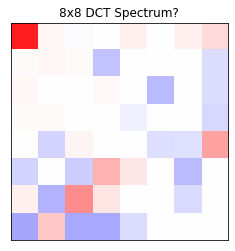

In [43]:
imgplot = plt.imshow(DCT_spectrum8x8np,cmap="bwr",vmin=-1,vmax=1)  #jpegファイルの描画
imgplot.axes.set_xticks([]) #x軸の目盛を削除
imgplot.axes.set_yticks([]) #y軸の目盛を削除
imgplot.axes.set_title("8x8 DCT Spectrum?")

Text(0.5, 1.0, 'first 8x8 block of original image')

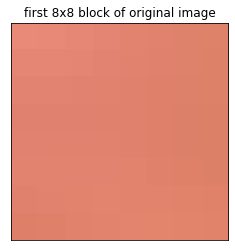

In [44]:
img[0:8,0:8,:]
imgplot = plt.imshow(img[0:8,0:8,:])  #jpegファイルの描画
imgplot.axes.set_xticks([]) #x軸の目盛を削除
imgplot.axes.set_yticks([]) #y軸の目盛を削除
imgplot.axes.set_title("first 8x8 block of original image")

Text(0.5, 1.0, 'first 8x8 Y block of target')

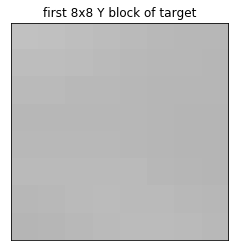

In [45]:
Y_img =  0.29900 * img[:,:,0]/255. + 0.58700 * img[:,:,1]/255. + 0.11400  * img[:,:,2]/255.
Cb_img = -0.1687 * img[:,:,0]/255. - 0.33126 * img[:,:,1]/255. + 0.50000 * img[:,:,2]/255.
Cr_img = 0.5000  * img[:,:,0]/255.- 0.41869  * img[:,:,1]/255. - 0.081   * img[:,:,2]/255.
imgplot = plt.imshow(1-Y_img[0:8,0:8],cmap="Greys",vmin=0,vmax=1)  #jpegファイルの描画
imgplot.axes.set_xticks([]) #x軸の目盛を削除
imgplot.axes.set_yticks([]) #y軸の目盛を削除
imgplot.axes.set_title("first 8x8 Y block of target")

In [46]:
import scipy as sp
import scipy.fftpack as fft

IDCT_Y=fft.idct(fft.idct(DCT_spectrum8x8np,n=8,axis=0,norm='ortho'),n=8,axis=1,norm='ortho')

Text(0.5, 1.0, 'first 8x8 block Y conp')

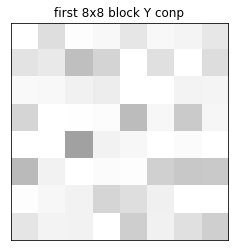

In [47]:
imgplot = plt.imshow(IDCT_Y,cmap="Greys",vmin=0,vmax=1)  #jpegファイルの描画
imgplot.axes.set_xticks([]) #x軸の目盛を削除
imgplot.axes.set_yticks([]) #y軸の目盛を削除
imgplot.axes.set_title("first 8x8 block Y conp")

Text(0.5, 1.0, '8x8 DCT Spectrum?')

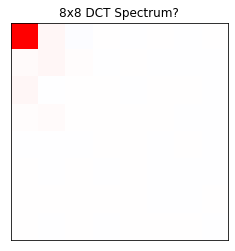

In [48]:
target_Y_spectrum=fft.dct(fft.dct(Y_img[0:8,0:8],n=8,axis=0,norm='ortho'),n=8,axis=1,norm='ortho')

imgplot = plt.imshow(target_Y_spectrum,cmap="bwr",vmin=-1,vmax=1)  #jpegファイルの描画
imgplot.axes.set_xticks([]) #x軸の目盛を削除
imgplot.axes.set_yticks([]) #y軸の目盛を削除
imgplot.axes.set_title("8x8 DCT Spectrum?")

In [49]:
(target_Y_spectrum*255).astype("int")

array([[1249,    9,   -2,    0,    0,    0,    0,    0],
       [   4,    9,    3,    0,    0,    0,    0,    0],
       [   8,    0,    0,    0,    0,    0,    0,    0],
       [   3,    5,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0]])